In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Fault Condition 2 and 3 is all about the mixing air temperature sensor on the AHU

Schematic below is from this blog about HVAC: https://www.hvacbrain.com/blog/vav-versus-vvt/

* FC2 is MIN legitimate value that the mix air sensor should ever read AND
* FC3 is MAX legitimate value that the mix air sensor should ever

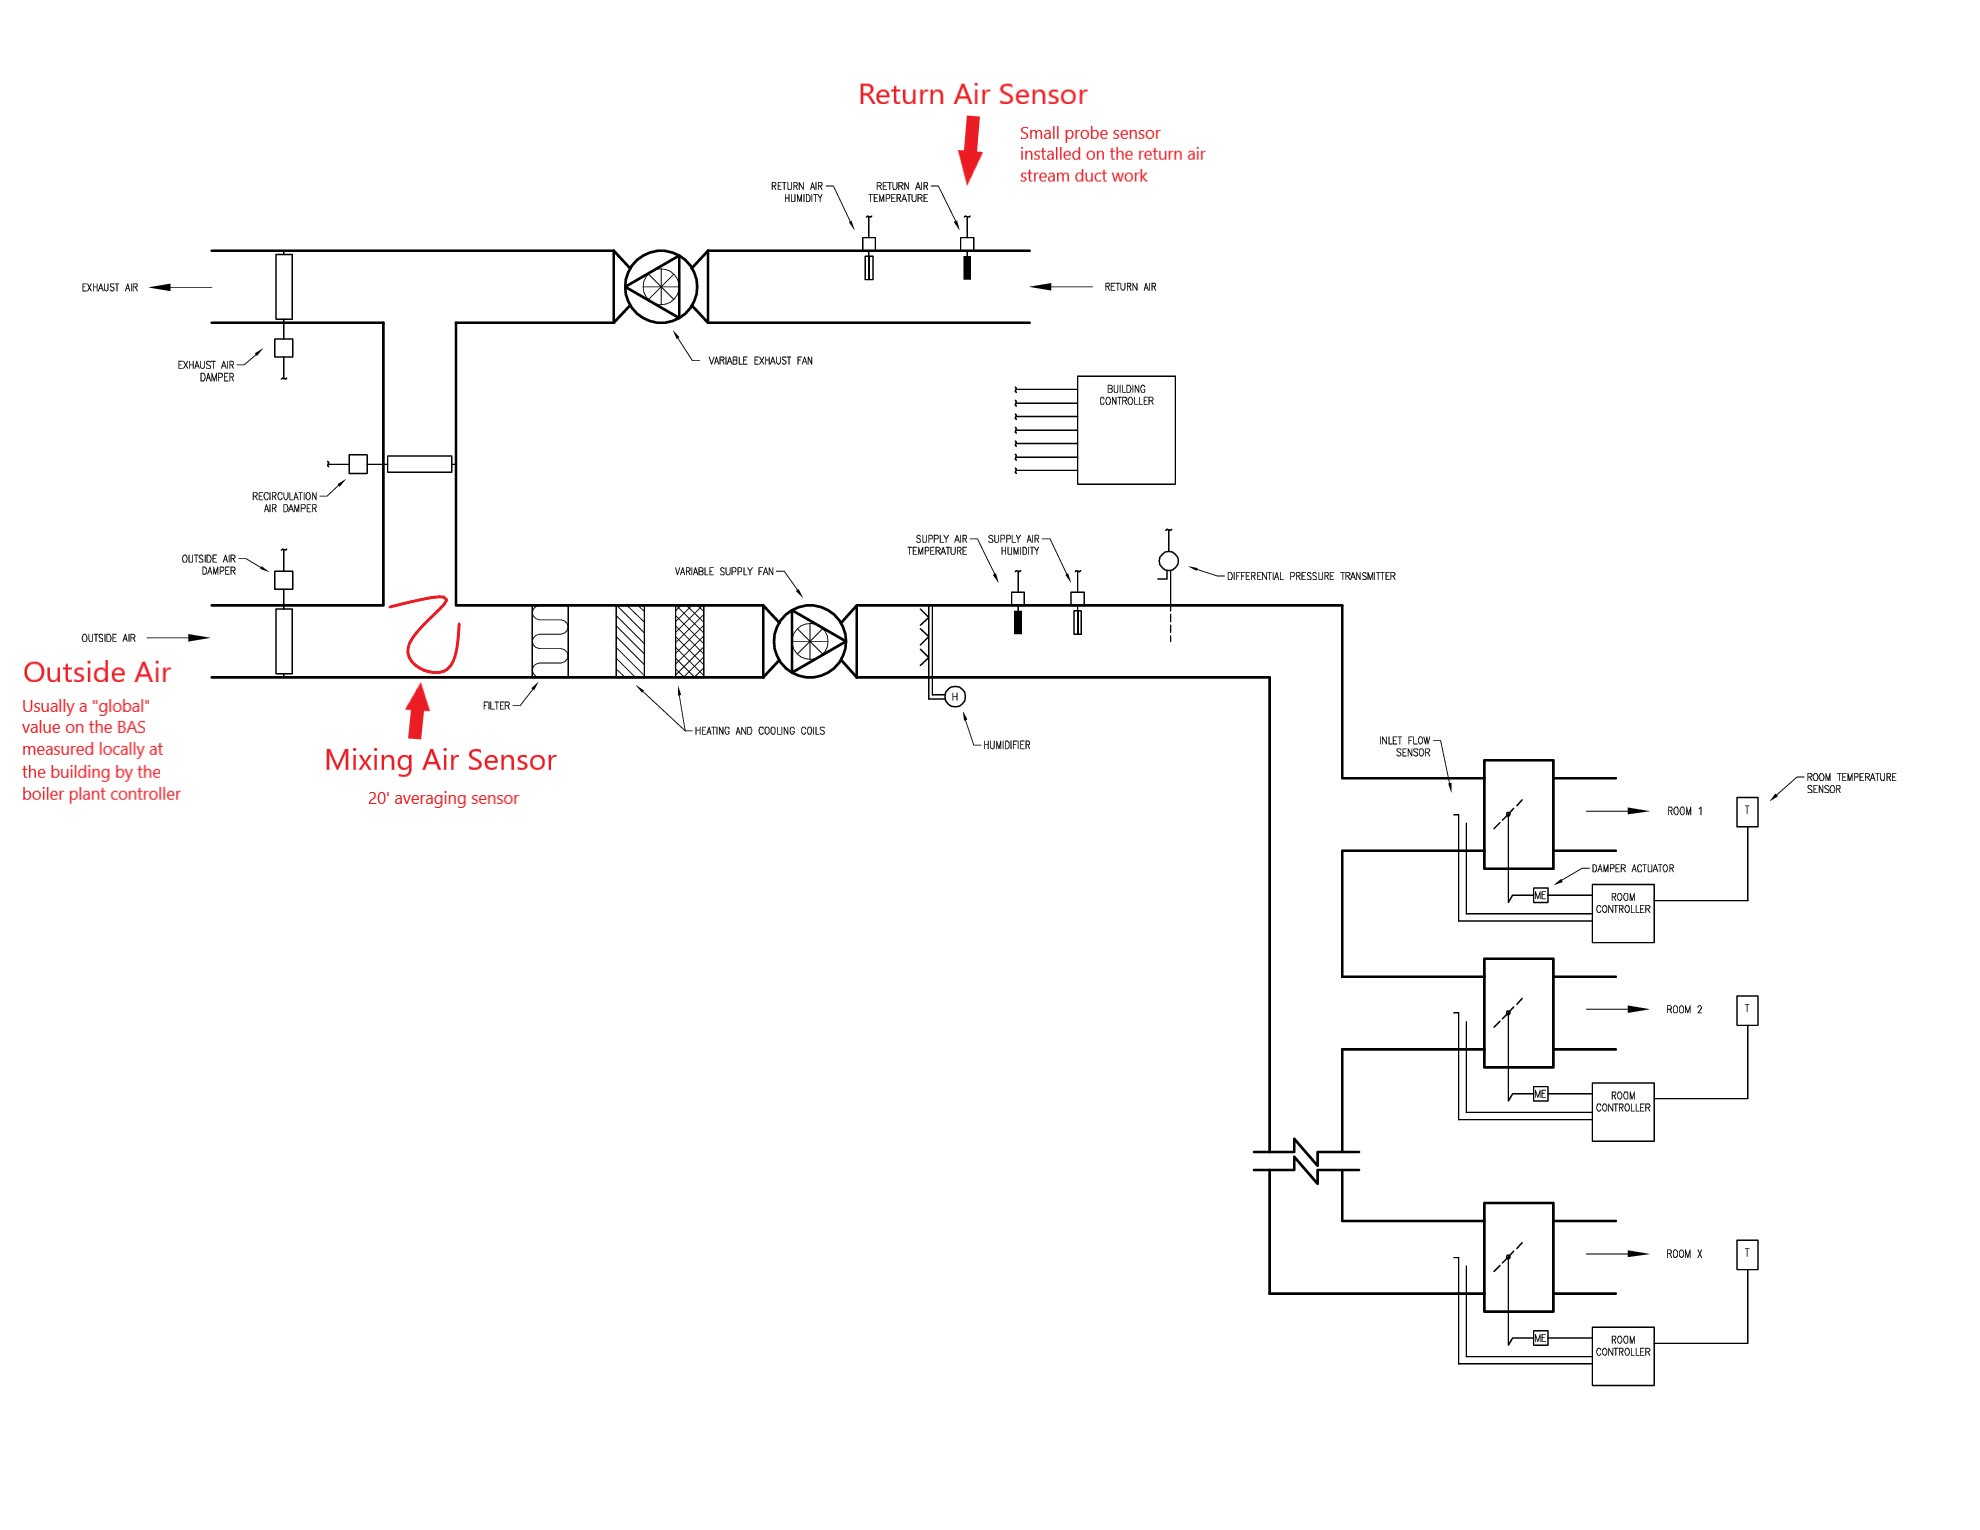

* I think the theory is when blending air streams together or "mixing" the air streams the sensor value should be within some range defined in thermodynamics. The analogy would be what would be the possible theoretical ranges of temperatures when blending a hot cup of coffee with a cup of ice water? Well, that statement depends on how much cold ice water and is blended with how much hot coffee, but the resulting mixing temperature would never ever be outside the range of the coffee or ice water but somewhere in between... Seems obvious, right? For HVAC mixing return air with some % of outside air at some given temperature the results should be pretty obvious.

# This measure applies to all "MODES" for AHU. I.E., heating, cooling, economizer, etc. Defined as a OS#

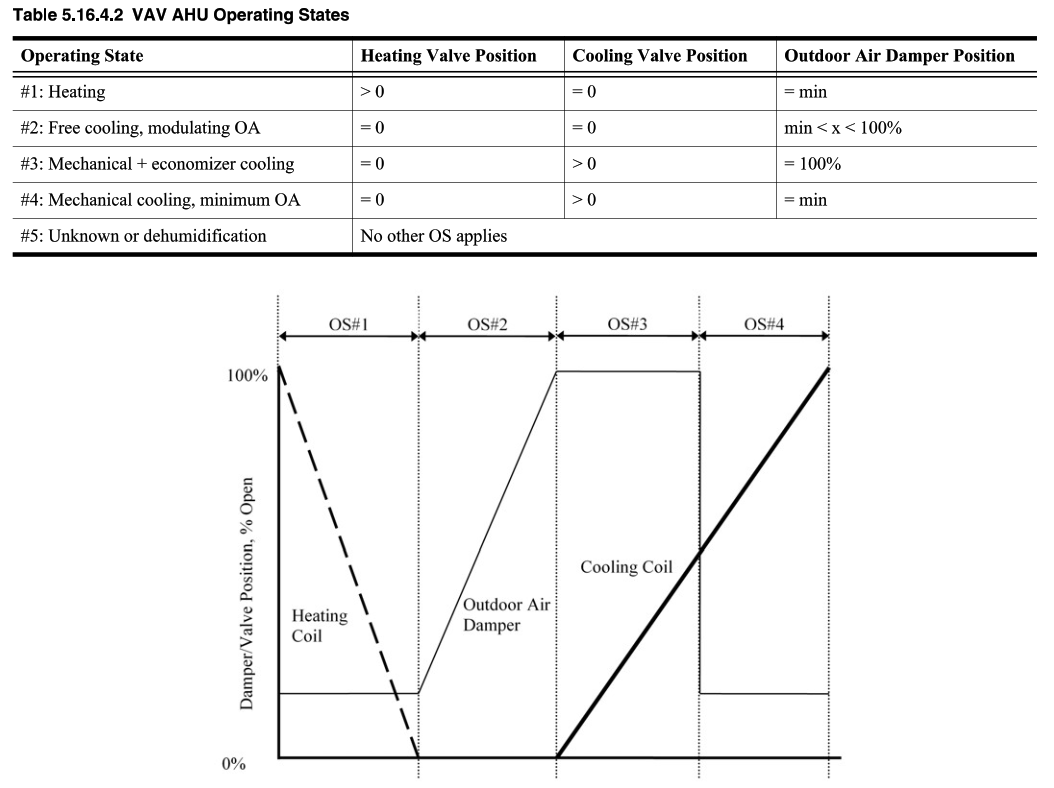

* This image above denotes a heating mode, economizer mode, economizer + mechanical cooling, and mechanical cooling only moving left to right based on the data coming from the heating valve, outside air damper, and cooling.

# Snip of ASHRAE Fault Condition 2

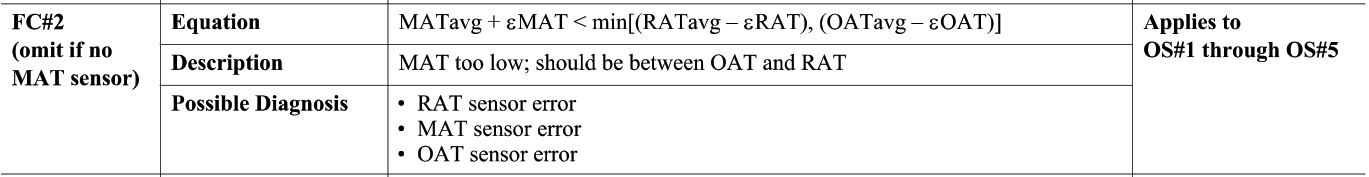

In [2]:
def fault_condition_two_(dataframe):
    return (dataframe.mat + dataframe.mix_degf_err_thres < np.minimum((dataframe.rat - dataframe.return_degf_err_thres) , (dataframe.oat - dataframe.outdoor_degf_err_thres)))

# Snip of ASHRAE Fault Condition 3 

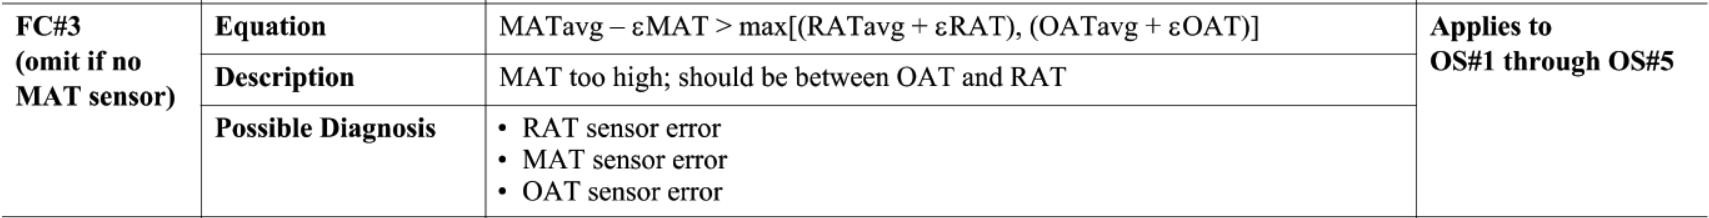

In [3]:
def fault_condition_three_(dataframe):
    return (dataframe.mat - dataframe.mix_degf_err_thres > np.maximum((dataframe.rat + dataframe.return_degf_err_thres) , (dataframe.oat + dataframe.outdoor_degf_err_thres)))

# Read Associated CSV files forward fill dataset and remove NaNs

In [4]:
rtu_temps = pd.read_csv('./summer_data/RTU Temperatures-data-as-seriestocolumns-2021-11-05 12_04_38.csv', index_col='Time', parse_dates=True).fillna(method='ffill').dropna()

# Compute 5 Min Rolling Avg Per G36 Spec

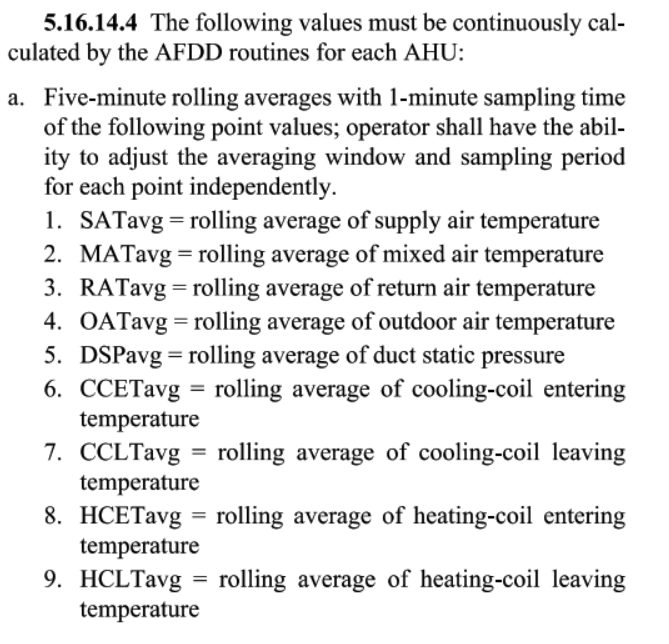

In [5]:
rtu_temps_avg = rtu_temps.rolling('5T').mean()

rtu_temps_avg.head()

,slipstream_internal/slipstream_hq/1100/Discharge Air Temperature,slipstream_internal/slipstream_hq/1100/Mixed Air Temperature Local,slipstream_internal/slipstream_hq/1100/Return Air Temperature,slipstream_internal/slipstream_hq/1100/Discharge Air Cooling Setpoint BAS,slipstream_internal/slipstream_hq/1002/Outside Air Temperature local
Time,,,,,
2021-08-09 00:00:00,78.4,76.70,76.4,55.0,70.5
2021-08-09 00:01:00,78.4,76.70,76.4,55.0,70.5
2021-08-09 00:01:00,78.4,76.70,76.4,55.0,70.5
2021-08-09 00:02:00,78.4,76.70,76.4,55.0,70.5
2021-08-09 00:02:00,78.4,76.68,76.4,55.0,70.5


In [6]:
rtu_temps_avg.columns

Index(['slipstream_internal/slipstream_hq/1100/Discharge Air Temperature',
       'slipstream_internal/slipstream_hq/1100/Mixed Air Temperature Local',
       'slipstream_internal/slipstream_hq/1100/Return Air Temperature',
       'slipstream_internal/slipstream_hq/1100/Discharge Air Cooling Setpoint BAS',
       'slipstream_internal/slipstream_hq/1002/Outside Air Temperature local'],
      dtype='object')

In [7]:
# rename columns
rtu_temps_avg.rename(columns={'slipstream_internal/slipstream_hq/1100/Discharge Air Temperature': 'dat', # discharge air temp not needed
                   'slipstream_internal/slipstream_hq/1100/Mixed Air Temperature Local': 'mat',
                   'slipstream_internal/slipstream_hq/1100/Return Air Temperature': 'rat',
                   'slipstream_internal/slipstream_hq/1100/Discharge Air Cooling Setpoint BAS': 'dat_sp', # discharge air sp temp not needed
                   'slipstream_internal/slipstream_hq/1002/Outside Air Temperature local': 'oat'}, inplace=True)

In [8]:
rtu_temps_avg = rtu_temps_avg[['mat', 'rat', 'oat']]

In [9]:
rtu_temps_avg.columns

Index(['mat', 'rat', 'oat'], dtype='object')

In [10]:
# small dataset logged from VOLTTRON on 1 min intervals.
# Its about 3 days of data which was the max my
# web browser could handle retrieving the data
# via grafana interface

rtu_temps_avg.describe()

,mat,rat,oat
count,14390.000000,14390.000000,14390.000000
mean,75.287426,73.929098,76.274771
std,4.264325,2.697062,8.814327
min,67.922222,68.400000,62.777778
25%,71.766667,72.440000,68.880000
50%,74.933333,73.557778,72.627778
75%,79.028056,75.200000,84.360000
max,83.888889,82.444444,97.988889


# Plot data for visulation 

array([<AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>], dtype=object)

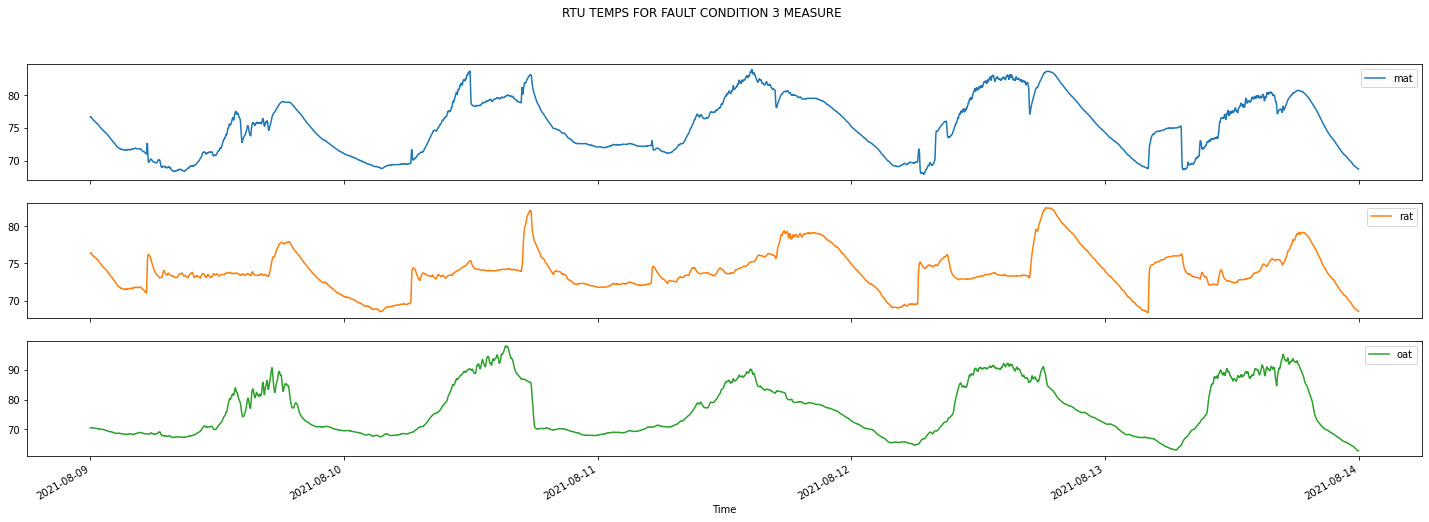

In [11]:
rtu_temps_avg.plot(figsize=(25,8), subplots=True, title='RTU TEMPS FOR FAULT CONDITION 3 MEASURE')

* Note hot weather in summer data above. oat = Outdoor Temp, rat = Return Air Temp, mat = Mix Air Temp

# Set Internal Variables per G36 Spec Imperial Units

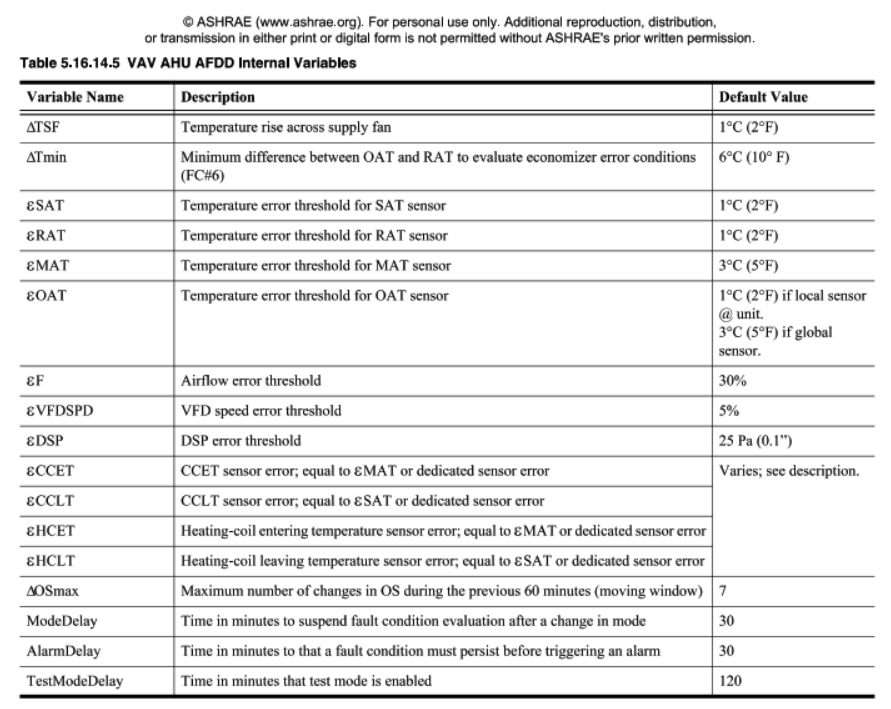

In [12]:
supply_fan_delta_degf = 2.
oat_rat_delta_degf_min = 10.
supply_degf_err_thres = 2.
return_degf_err_thres = 2.
mix_degf_err_thres = 5.
outdoor_degf_err_thres = 5. # local OAT options Vs global OAT sensor
air_flow_percent_thres = .3
vfd_speed_percent_err_thres = .05
vfd_speed_percent_max = .99
duct_static_inches_err_thres = .1
delta_os_max = 7.
mode_delay = 30.
alarm_dely = 30.
test_mode_delay = 120.

In [13]:
# make an entire column out of these params in the Pandas Dataframe
rtu_temps_avg['outdoor_degf_err_thres'] = outdoor_degf_err_thres
rtu_temps_avg['mix_degf_err_thres'] = mix_degf_err_thres
rtu_temps_avg['return_degf_err_thres'] = return_degf_err_thres

In [14]:
rtu_temps_avg.columns

Index(['mat', 'rat', 'oat', 'outdoor_degf_err_thres', 'mix_degf_err_thres',
       'return_degf_err_thres'],
      dtype='object')

In [15]:
# Create a debug dataframe for later
rtu_temps_debug =  rtu_temps_avg.copy()

# Run dataset through the function created for FC3 to FLAG some faults!

In [16]:
rtu_temps_avg['fc3_flag'] = fault_condition_three_(rtu_temps_avg)

In [17]:
rtu_temps_avg['fc3_flag'].value_counts()

False    14390
Name: fc3_flag, dtype: int64

In [18]:
rtu_temps_avg.columns

Index(['mat', 'rat', 'oat', 'outdoor_degf_err_thres', 'mix_degf_err_thres',
       'return_degf_err_thres', 'fc3_flag'],
      dtype='object')

In [19]:
# change boolean column to int for plots

rtu_temps_avg['fc3_flag'] = rtu_temps_avg['fc3_flag'].astype(int)

# drop params column for better plot
rtu_temps_avg = rtu_temps_avg.drop(['outdoor_degf_err_thres',
                  'mix_degf_err_thres',
                  'return_degf_err_thres'],axis=1)


In [20]:
fdd_plot = rtu_temps_avg

In [21]:
fdd_plot.columns

Index(['mat', 'rat', 'oat', 'fc3_flag'], dtype='object')

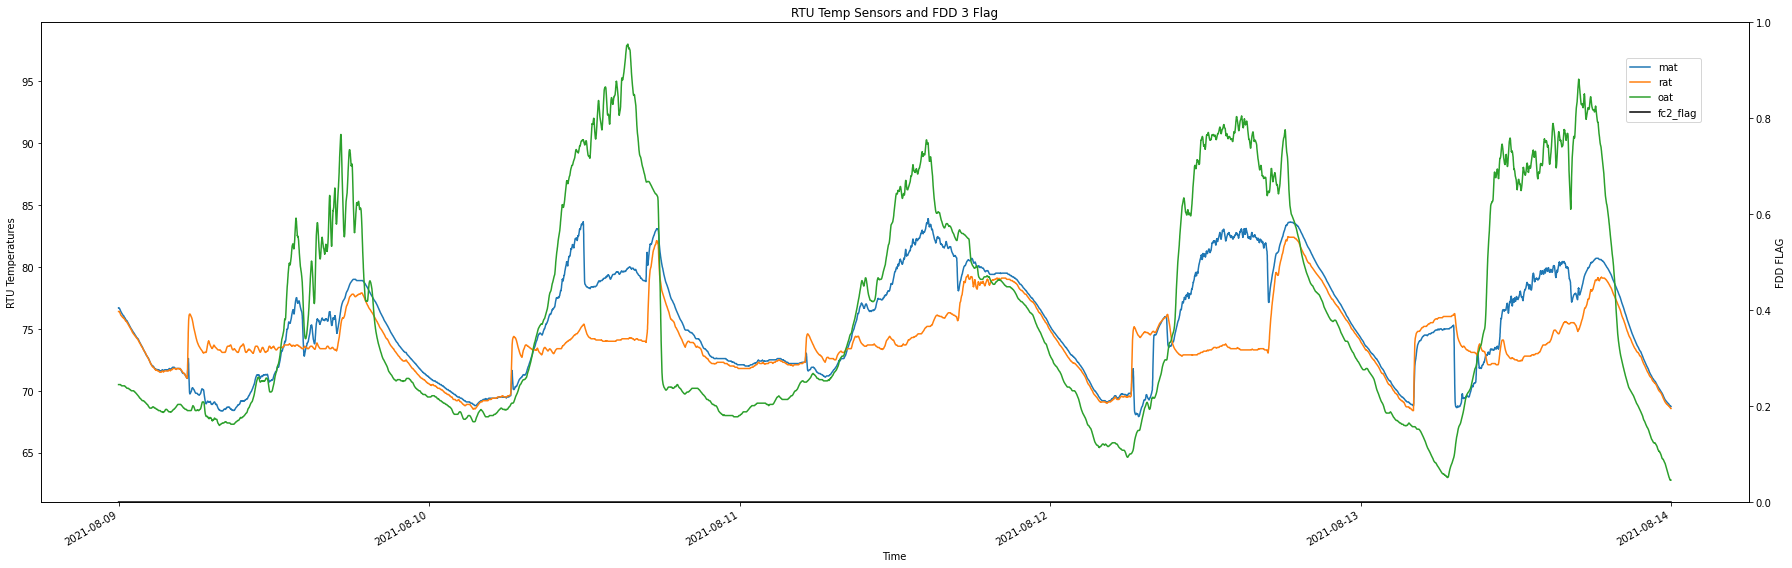

In [22]:
fig, ax = plt.subplots(figsize=(25,8))

plot1a = fdd_plot.mat.plot(ax=ax)
plot1b = fdd_plot.rat.plot(ax=ax)
plot1c = fdd_plot.oat.plot(ax=ax)
plot1d = fdd_plot.fc3_flag.plot(ax=ax, color='k', secondary_y=True)

ax.set_ylabel('RTU Temperatures')
ax.right_ax.set_ylim(0,1)
plt.ylabel('FDD FLAG')

ax.set_title("RTU Temp Sensors and FDD 3 Flag")
fig.legend(['mat','rat','oat','fc2_flag'],bbox_to_anchor=(.95, .9))

# defining display layout
plt.tight_layout()

# show plot
plt.show()


In [23]:
zoom_date = '2021-8-10'
fdd_plot_zoom1 = fdd_plot.loc[zoom_date]

# code here is to make the zoom plot x axis readable with units of time
fdd_plot_zoom1.index = fdd_plot_zoom1.index.map(lambda x: x.strftime("%H:%M"))

fdd_plot_zoom1.head()

,mat,rat,oat,fc3_flag
Time,,,,
00:00,71.100000,70.555556,69.5,0
00:00,71.090000,70.550000,69.5,0
00:01,71.077778,70.533333,69.5,0
00:01,71.070000,70.530000,69.5,0
00:02,71.055556,70.511111,69.5,0


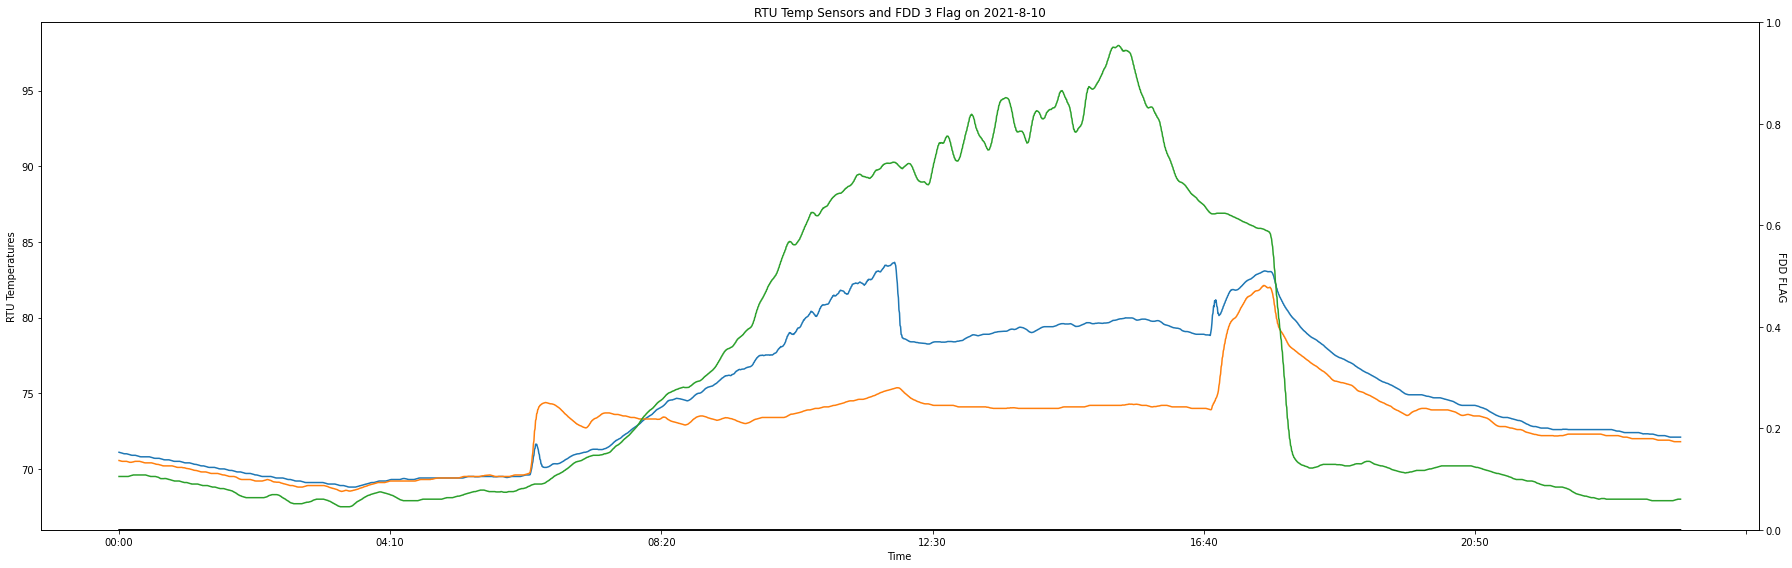

In [24]:
fig1, ax = plt.subplots(figsize=(25,8))

fdd_plot_zoom1.mat.plot(ax=ax)
fdd_plot_zoom1.rat.plot(ax=ax)
fdd_plot_zoom1.oat.plot(ax=ax)
fdd_plot_zoom1.fc3_flag.plot(ax=ax, color='k', secondary_y=True)

ax.set_ylabel('RTU Temperatures')
ax.right_ax.set_ylim(0,1)
plt.ylabel('FDD FLAG', rotation=-90)

ax.set_title("RTU Temp Sensors and FDD 3 Flag on " + zoom_date)
fig.legend(['mat','rat','oat','fc3_flag'],bbox_to_anchor=(.95, .9))

# defining display layout
plt.tight_layout()

# show plot
plt.show()

# WHY NO FAULTS?

* maybe look at our equation again....? Which is opposite of FC2

return mat - mat_err > max((rat + rat_err) , (oat + oat_err))

In [25]:
# use our debug dataframe created earlier

# IS THIS CALC
rtu_temps_debug['mix_err_calc'] = rtu_temps_debug.mat - rtu_temps_debug.mix_degf_err_thres

# GREATER THAN THE MIN OF THIS CALC!!!!
rtu_temps_debug['return_err_calc'] = rtu_temps_debug.rat + rtu_temps_debug.return_degf_err_thres
rtu_temps_debug['outdoor_err_calc'] = rtu_temps_debug.oat + rtu_temps_debug.outdoor_degf_err_thres

rtu_temps_debug.head()

,mat,rat,oat,outdoor_degf_err_thres,mix_degf_err_thres,return_degf_err_thres,mix_err_calc,return_err_calc,outdoor_err_calc
Time,,,,,,,,,
2021-08-09 00:00:00,76.70,76.4,70.5,5.0,5.0,2.0,71.70,78.4,75.5
2021-08-09 00:01:00,76.70,76.4,70.5,5.0,5.0,2.0,71.70,78.4,75.5
2021-08-09 00:01:00,76.70,76.4,70.5,5.0,5.0,2.0,71.70,78.4,75.5
2021-08-09 00:02:00,76.70,76.4,70.5,5.0,5.0,2.0,71.70,78.4,75.5
2021-08-09 00:02:00,76.68,76.4,70.5,5.0,5.0,2.0,71.68,78.4,75.5


In [26]:
rtu_temps_debug = rtu_temps_debug.drop(['return_degf_err_thres',
                                        'outdoor_degf_err_thres',
                                        'mix_degf_err_thres',
                                        'oat',
                                        'mat',
                                        'rat'],axis=1)

rtu_temps_debug.head()

,mix_err_calc,return_err_calc,outdoor_err_calc
Time,,,
2021-08-09 00:00:00,71.70,78.4,75.5
2021-08-09 00:01:00,71.70,78.4,75.5
2021-08-09 00:01:00,71.70,78.4,75.5
2021-08-09 00:02:00,71.70,78.4,75.5
2021-08-09 00:02:00,71.68,78.4,75.5


In [27]:
rtu_temps_debug.describe()

,mix_err_calc,return_err_calc,outdoor_err_calc
count,14390.000000,14390.000000,14390.000000
mean,70.287426,75.929098,81.274771
std,4.264325,2.697062,8.814327
min,62.922222,70.400000,67.777778
25%,66.766667,74.440000,73.880000
50%,69.933333,75.557778,77.627778
75%,74.028056,77.200000,89.360000
max,78.888889,84.444444,102.988889


# DOES THE BLUE LINE EVER RISE ABOVE THE MAX OF EITHER THE ORANGE OR GREEN LINE? 

* looks like a big fat no, so maybe the mixing air temperature sensor is reading legit values

<AxesSubplot:xlabel='Time'>

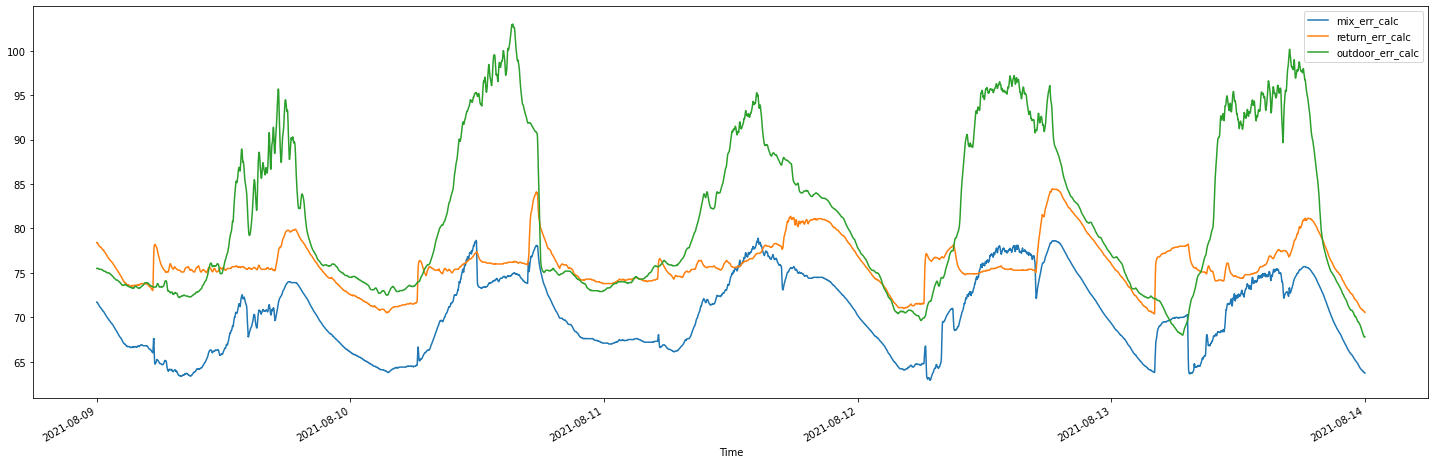

In [28]:
rtu_temps_debug.plot(figsize=(25,8))

# The second D in FDD is "Diagnostics"

No diagnostics on this one as there appears to be no FLAGS!

* Calculate percent TRUE AND FALSE of FDD Flag

In [29]:
percent_true = rtu_temps_avg.fc3_flag.mean()

print("Percent of time in the dataset when FLAG is True")

percent_true

Percent of time in the dataset when FLAG is True


0.0

In [30]:
percent_false = 1 - percent_true

print("Percent of time in the dataset when FLAG is False")

percent_false

Percent of time in the dataset when FLAG is False


1.0

* Calculate elapsed time for fault conditions True

In [31]:
fc3_dataset_copy = rtu_temps_avg.copy()


#filter dataset for when "FLAG" is True
fc3_dataset_copy = fc3_dataset_copy[fc3_dataset_copy.fc3_flag == 1]


In [32]:
fc3_dataset_copy.fc3_flag.sum()

0

In [33]:
fc3_dataset_copy['time_td'] = fc3_dataset_copy.index.to_series().diff().astype('timedelta64[m]')

In [34]:
print("TIME IN MINUTES the FLAG is TRUE")

fc3_dataset_copy.time_td.sum()

TIME IN MINUTES the FLAG is TRUE


0.0

In [35]:
print("TIME IN HOURS the FLAG is TRUE")

fc3_dataset_copy.time_td.sum() / 60

TIME IN HOURS the FLAG is TRUE


0.0

* Plot on histogram the hour of the day the "FLAG" is TRUE

<AxesSubplot:title={'center':'Hour Of Day When Flag is TRUE'}, ylabel='Frequency'>

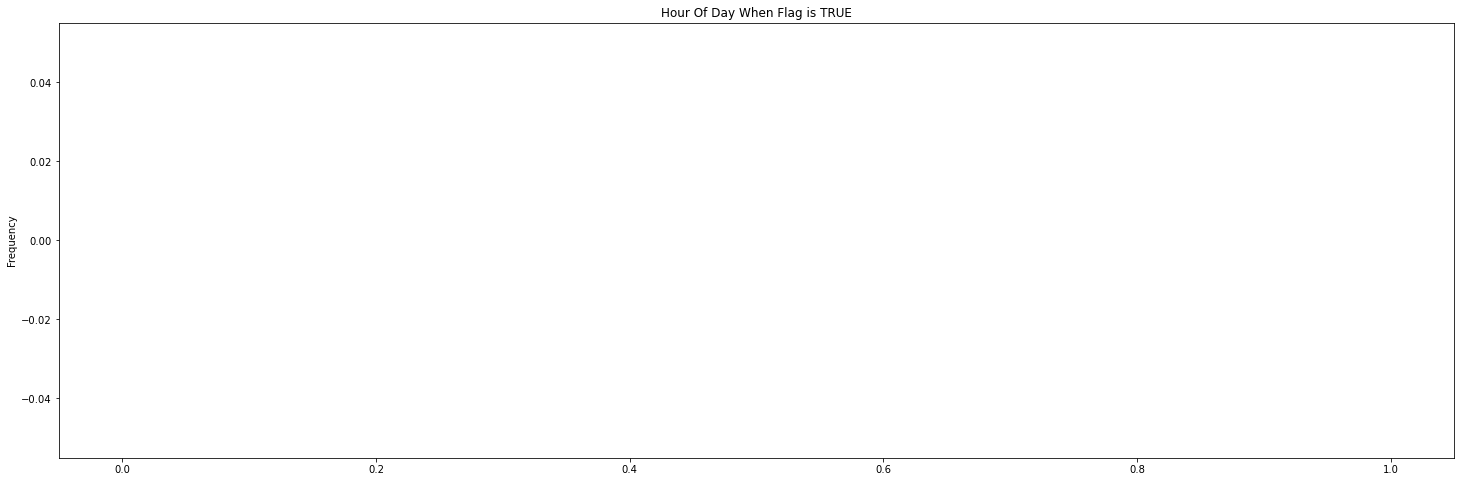

In [36]:
fc3_dataset_copy['hour_of_the_day'] = fc3_dataset_copy.index.hour

fc3_dataset_copy.hour_of_the_day.plot.hist(title='Hour Of Day When Flag is TRUE',figsize=(25,8))

In [37]:
print("Mix Air Temp Average for dataset when FLAG IS TRUE")

fc3_dataset_copy.mat.mean()

Mix Air Temp Average for dataset when FLAG IS TRUE


nan